In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
import spikeA.spatial_properties

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

In [2]:
path="/adata/electro/bt0975/bt0975-28092021-0105"
name="bt0975-28092021-0105"

In [3]:
ses = Kilosort_session(name=name,path=path)
ses.load_parameters_from_files()
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = bt0975-28092021-0105
path = /adata/electro/bt0975/bt0975-28092021-0105
subject = bt0975
session_dat_time = 2021-09-28 01:05:00
fileBase = /adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105
file_names = {'par': '/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.par', 'desen': '/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.desen', 'desel': '/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.desel', 'sampling_rate': '/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.sampling_rate_dat', 'px_per_cm': '/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.px_per_cm', 'params': '/adata/electro/bt0975/bt0975-28092021-0105/params.py', 'amplitudes': '/adata/electro/bt0975/bt0975-28092021-0105/amplitudes.npy', 'channel_map': '/adata/electro/bt0975/bt0975-28092021-0105/channel_map.npy', 'channel_positions': '/adata/electro/bt0975/bt0975-28092021-0105/channel_positions.

In [4]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
cg = Cell_group(stl)

Number of good clusters: 37


In [5]:
ap = Animal_pose(ses)

fn = ap.ses.fileBase+ap.pose_file_extension
print(fn)

if os.path.exists(fn):
    print("npy file found:",fn)
    ap.load_pose_from_file()
else:
    print("load from positrack")
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50,extension="trk")
    #print("save to npy for later use")
    #ap.save_pose_to_file() # save the file for next time
    

/adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.pose.npy
npy file found: /adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.pose.npy
Loading original pose from /adata/electro/bt0975/bt0975-28092021-0105/bt0975-28092021-0105.pose.npy


In [6]:
circ80_indices = [i for i, j in enumerate(ses.desen) if j == 'circ80']
first_circ80_index = circ80_indices[0]

first_circ80_inter = ses.trial_intervals.inter[first_circ80_index] # first circ80

print(first_circ80_inter)

ap.unset_intervals()
ap.set_intervals(np.array([first_circ80_inter]))



[   0.      1267.52395]


### Doughnut

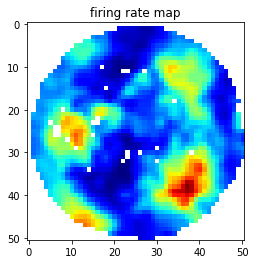

found 59 peaks
midpoint = origin of coordinate system: [51.5 51.5]
maxradius 51.5


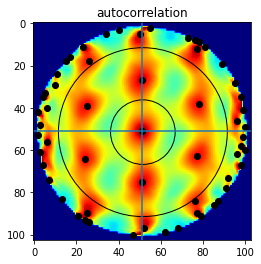

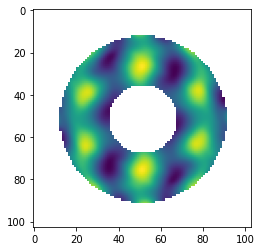

In [7]:
import math

n = cg.neuron_list[2]
n.set_spatial_properties(ap)
n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)


# artificial firing map to test doughnut function
#n.spatial_properties.firing_rate_map = np.zeros((50,50))
#n.spatial_properties.firing_rate_map[20:23,20:23]=1


plt.imshow(n.spatial_properties.firing_rate_map, cmap='jet')
plt.title("firing rate map")
plt.show()

n.spatial_properties.spatial_autocorrelation_map_2d()
plt.imshow(n.spatial_properties.spatial_autocorrelation_map, cmap='jet')
plt.title("autocorrelation")

n.spatial_properties.spatial_autocorrelation_field_detection(.05, 4)
x,y = n.spatial_properties.spatial_autocorrelation_field
plt.axhline(y=51)
plt.axvline(x=51)
plt.scatter(x,y, color='black')

xylist = np.unique([(x_,y_) for x_,y_ in zip(x,y)] ,axis=0)

print("found",len(x),"peaks")
#print("xylist:",xylist)
#print(n.spatial_properties.spatial_autocorrelation_map.shape,x,y)

#print(np.where(n.spatial_properties.spatial_autocorrelation_map==1.))




r_inner = 10
r_outer_range = np.linspace(10,50,100)

midpoint = np.array(n.spatial_properties.spatial_autocorrelation_map.shape)/2
print("midpoint = origin of coordinate system:",midpoint)


maxradius = np.min(np.array(n.spatial_properties.spatial_autocorrelation_map.shape))/2
print("maxradius",maxradius)

r_outer_radii = []

# find proper dimensions for doughnut
for r_outer in r_outer_range:
    points_inside_dougnut= [ (x_,y_) for x_,y_ in zip(x,y) if math.dist(midpoint, [x_,y_]) < r_outer ]
    if(len(points_inside_dougnut)>=7):
        r_outer_radii.append(r_outer)

if len(r_outer_radii):

    r_outer_radius_contains6 = r_outer_radii[0] # np.mean(r_outer_radii)

    r_outer_radius_use = r_outer_radius_contains6*1.3
    r_inner_radius_use = r_outer_radius_contains6*0.5

    r_outer_radius_use = np.round(np.min([r_outer_radius_use, maxradius*0.9]))

else:
    r_outer_radius_use = maxradius*0.9
    r_inner_radius_use = r_outer_radius_use/1.3*0.9


circle_outer = plt.Circle((midpoint[0], midpoint[1]), r_outer_radius_use, color='black' , fill=False)
circle_inner = plt.Circle((midpoint[0], midpoint[1]), r_inner_radius_use, color='black' , fill=False)


fig = plt.gcf()
ax = fig.gca()

ax.add_patch(circle_outer)
ax.add_patch(circle_inner)
plt.show()



doughnut = n.spatial_properties.spatial_autocorrelation_map


outsidedoughnut = np.array([ np.array([x_,y_]) for x_,y_ in np.ndindex(n.spatial_properties.spatial_autocorrelation_map.shape) if math.dist(midpoint, [x_,y_]) < r_inner_radius_use or math.dist(midpoint, [x_,y_]) > r_outer_radius_use ])
outsidedoughnut = (outsidedoughnut[:,0], outsidedoughnut[:,1])
doughnut[outsidedoughnut] = np.nan


plt.imshow(doughnut)


plt.show()

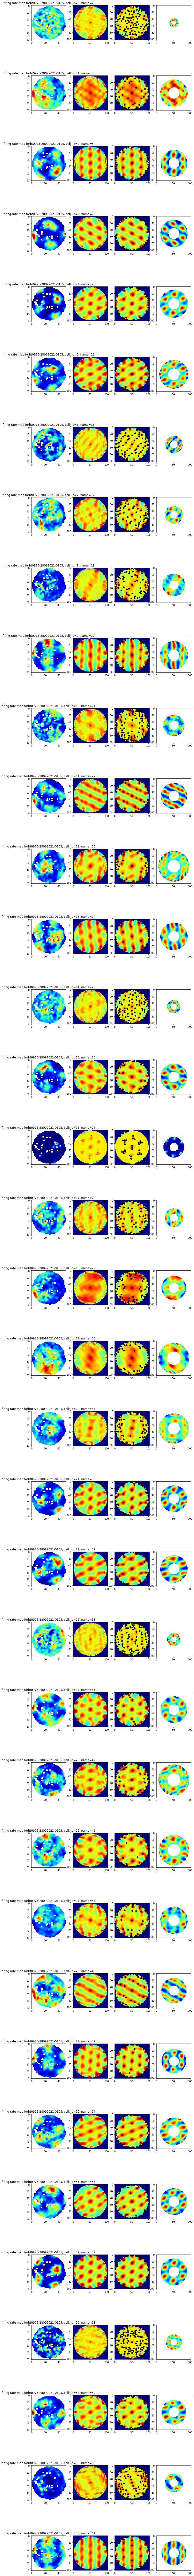

In [8]:
# maxradius = np.min(np.array(cg.neuron_list[0].spatial_properties.spatial_autocorrelation_map.shape))/2
# print("maxradius",maxradius)
# midpoint = np.array(cg.neuron_list[0].spatial_properties.spatial_autocorrelation_map.shape)/2
# print("midpoint = origin of coordinate system:",midpoint)
# r_outer_range = np.linspace(10,50,100)




# calculate firing map for all neurons

fig, axs = plt.subplots(len(cg.neuron_list),4,figsize=(12,200))

for i, n in enumerate(cg.neuron_list):
    
#    if i>7:
#        continue
        
    n.set_spatial_properties(ap)
    
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    axs[i,0].imshow(n.spatial_properties.firing_rate_map, cmap='jet')
    axs[i,0].set_title("firing rate map for"+name+", cell: id="+str(i)+", name="+n.name)

    
    n.spatial_properties.spatial_autocorrelation_map_2d()
    axs[i,1].imshow(n.spatial_properties.spatial_autocorrelation_map, cmap='jet')
    
    
    
    
    axs[i,2].imshow(n.spatial_properties.spatial_autocorrelation_map, cmap='jet')
    
    n.spatial_properties.spatial_autocorrelation_field_detection(threshold = 0.1, neighborhood_size = 5)
    x,y = n.spatial_properties.spatial_autocorrelation_field
    
    axs[i,2].scatter(x,y, color='black')
    
    
    
    
    '''
    
    r_outer_radii = []
    
    # find proper dimensions for doughnut
    for r_outer in r_outer_range:
        points_inside_dougnut= [ (x_,y_) for x_,y_ in zip(x,y) if math.dist(midpoint, [x_,y_]) < r_outer ]
        if(len(points_inside_dougnut)>=7):
            r_outer_radii.append(r_outer)
    
    if len(r_outer_radii):
    
        r_outer_radius_contains6 = r_outer_radii[0] # np.mean(r_outer_radii)
        
        r_outer_radius_use = r_outer_radius_contains6*1.3
        r_inner_radius_use = r_outer_radius_contains6*0.5
        
        r_outer_radius_use = np.round(np.min([r_outer_radius_use, maxradius*0.9]))
        
    else:
        r_outer_radius_use = maxradius*0.9
        r_inner_radius_use = r_outer_radius_use/1.3*0.9

        
    #circle_6 = plt.Circle((midpoint[0], midpoint[1]), r_outer_radius_contains6, color='white' , fill=False)
    #circle_border = plt.Circle((midpoint[0], midpoint[1]), maxradius*0.9, color='red' , fill=False)

    circle_outer = plt.Circle((midpoint[0], midpoint[1]), r_outer_radius_use, color='black' , fill=False)
    circle_inner = plt.Circle((midpoint[0], midpoint[1]), r_inner_radius_use, color='black' , fill=False)

    



    axs[i,1].add_patch(circle_outer)
    axs[i,1].add_patch(circle_inner)

    #axs[i,1].add_patch(circle_6)
    #axs[i,1].add_patch(circle_border)
    
    '''
    
    n.spatial_properties.calculate_doughnut()
    doughnut = n.spatial_properties.doughnut
    
    axs[i,3].imshow(doughnut, cmap='jet')
    
    

plt.show()
    

    
    
    